<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/cnn_cifar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN for image classification using PyTorch

In this section, we follow Chap. 8 of the [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book, and illustrate how to fit a CNN to a two-class version of CIFAR. We modify the code from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch8/1_convolution.ipynb)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from functools import partial
import os
import collections



In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


torch version 1.8.0+cu101
Tesla V100-SXM2-16GB
current device 0


# Get the data

We standardize the data. (The mean/std of the RGB channels are precomputed in the MLP version of this colab.)


In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [36]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
nclasses = 2
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

# Basics of convolution

Lets apply a set of `nfeatures` convolutional kernels to a gray scale image.

In [8]:
img, label = cifar2[0]
img_batch  = img.unsqueeze(0)
print(img_batch.shape)

nfeatures = 16
kernel_size = 3
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size) 
output = conv(img_batch)
print(output.shape)


torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 30, 30])


Now we adding padding to ensure output size is same as input.

In [26]:
nfeatures = 16
kernel_size = 3
pad = kernel_size // 2
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size, padding=pad) 

output = conv(img_batch)
print(output.shape)

torch.Size([1, 16, 32, 32])


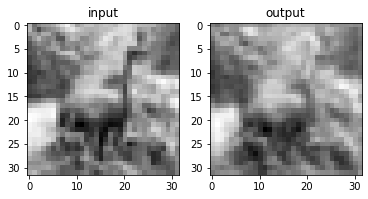

In [27]:
def show_results(img_batch, output_batch, index=0, channel=0):
  ax1 = plt.subplot(1, 2, 1)  
  img = img_batch[index] 
  plt.imshow(img.mean(0), cmap='gray')  
  plt.title('input')   
  plt.subplot(1, 2, 2) #, sharex=ax1, sharey=ax1) 
  plt.title('output')   
  out = output_batch[index, channel]
  plt.imshow(out.detach(), cmap='gray')
  plt.show()

show_results(img_batch, output)

Currently the filter parameters are random.

In [28]:
print(conv)
print(conv.weight.shape) # nfeatures x nchannels x kernel x kernel
print(conv.bias.shape) # nfeatures 
print(conv.weight[0,:,:,:])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([16, 3, 3, 3])
torch.Size([16])
tensor([[[-0.0514, -0.0149,  0.0366],
         [ 0.0002, -0.0002, -0.0093],
         [-0.0504, -0.0869,  0.0890]],

        [[ 0.0870,  0.1831, -0.0727],
         [ 0.1402,  0.0535, -0.0396],
         [-0.0514, -0.0437,  0.1690]],

        [[ 0.1595,  0.1416,  0.1176],
         [-0.1433, -0.0318, -0.0465],
         [-0.0076,  0.1596,  0.0303]]], grad_fn=<SliceBackward>)


Let's make the first filter just be an averaging operation.

tensor([[[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]]], grad_fn=<SliceBackward>)


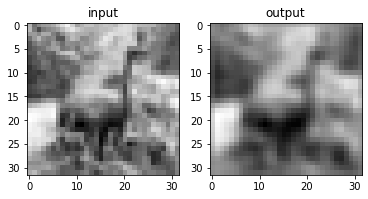

In [29]:

with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
print(conv.weight[0,:,:,:])

output_batch = conv(img_batch)
show_results(img_batch, output_batch)

Let's make the first filter be a vertical edge detector.

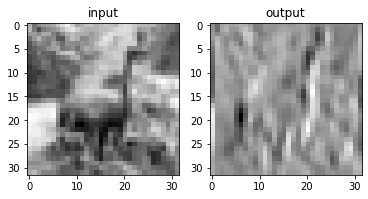

In [30]:

conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output_batch = conv(img_batch)
show_results(img_batch, output_batch)

# Max-pooling

We can reduce the size of the internal feature maps by using max-pooling.

torch.Size([1, 3, 16, 16])


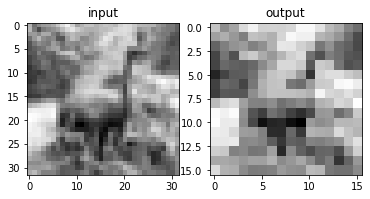

In [31]:
pool = nn.MaxPool2d(2)
output_batch = pool(img_batch)
print(output_batch.shape)

show_results(img_batch, output_batch)

# Making our first CNN

In [38]:
import torch.nn.functional as F

nchannels, nrows, ncols = img.shape

class Net(nn.Module):
    def __init__(self, nclasses, img):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        nchannels, nrows, ncols = img.shape
        # size of input to fc1 will be  8 * nrows/4 * ncols/4, 
        # since we will apply 2 maxpooling layers with size 2
        self.nflat = nrows//4 * ncols//4
        self.fc1 = nn.Linear(8 * self.nflat, 32)
        self.fc2 = nn.Linear(32, nclasses)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * self.nflat)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net(nclasses, img_batch[0])
out_batch = model(img_batch)
print(out_batch.shape)


torch.Size([1, 2])
